# Xarray
Xarray is a Python library that was built primarily for large-scale climate data analysis. Xarray is built upon Dask for distributed computation of NetCDF files and other gridded data sets. One such data set is the set of GCM runs from the CMIP5 and CMIP6 experiments, which cover multiple models at multiple resolutions (see [here](https://www.cesm.ucar.edu/projects/community-projects/MMLEA/)). First, we import the library, and like before, we start our Dask cluster:

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs # these are for land shapefiles
from dask.distributed import Client
client = Client(n_workers=1) # one worker organizes all tasks across all available threads in the thread pool
client

Client Scheduler: tcp://127.0.0.1:63571 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 17.18 GB


Xarray works in DataArrays (one variable) and DataSets (multiple variables). We can index multiple fields of gridded climate data in one Xarray object (think fancy DataFrame for gridded data) in one command. Here, we are indexing all of the daily precipitation, temperature at the surface, and specific humidity fields from the r1i1p1 ensemble member of the CanESM2 Global Climate Model (can download it [here](https://www.earthsystemgrid.org/dataset/ucar.cgd.ccsm4.CLIVAR_LE.canesm2_lens_new.html)). We can use the Xarray function for opening multiple files at once:

In [2]:
dataset = xr.open_mfdataset('*day*.nc', combine='by_coords',parallel=True)
dataset = dataset.drop(['height','lat_bnds','lon_bnds','time_bnds']) # we won't need these
dataset

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 55115)
Coordinates:
  * lat      (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 79.53 82.31 85.1 87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) object 1950-01-01 12:00:00 ... 2100-12-31 12:00:00
Data variables:
    huss     (time, lat, lon) float32 dask.array<chunksize=(55115, 64, 128), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(55115, 64, 128), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(55115, 64, 128), meta=np.ndarray>
Attributes:
    institution:               CCCma (Canadian Centre for Climate Modelling a...
    institute_id:              CCCma
    experiment_id:             historical-r1
    source:                    CanESM2
    model_id:                  CanESM2
    forcing:                   GHG,Oz,SA,BC,OC,LU,Sl,Vl (GHG includes CO2,CH4...
    parent_experiment_id:      N/A
    parent_experiment_rip:     N/A
    branch_time:               0.0
    contact:                   cccma_info@ec.gc.ca
    references:                http://www.cccma.ec.gc.ca/models
    initialization_method:     1
    physics_version:           1
    tracking_id:               b0f7b5f5-8824-4841-a280-e24b42826498
    branch_time_YMDH:          1950:01:01:00
    CCCma_runid:               eia-001
    CCCma_parent_runid:        igm
    CCCma_data_licence:        1) GRANT OF LICENCE - The Government of Canada...
    product:                   output
    experiment:                historical run
    frequency:                 day
    creation_date:             2014-09-04T16:35:31Z
    history:                   Thu Dec  6 08:55:31 2018: ncks -4 -L 1 huss_da...
    Conventions:               CF-1.4
    project_id:                CanSISE
    table_id:                  Table day (22 March 2012) d12339b33194a0b329de...
    title:                     CanESM2 model output prepared for CanSISE hist...
    parent_experiment:         N/A
    modeling_realm:            atmos
    realization:               1
    cmor_version:              2.8.2
    NCO:                       "4.5.2"
    nco_openmp_thread_number:  1

Since these all have the same space-time coordinates, Xarray combines them automatically along one set of coordinates after checking to make sure this is the case. Next, we can look at the data using Xarray plotting:

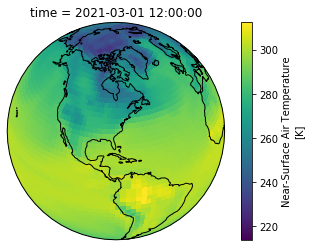

In [3]:
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
p = dataset.tas.sel(time='2021-03-01').plot(ax=ax,transform=ccrs.PlateCarree())
p.axes.set_global()
p.axes.coastlines()
plt.savefig('canesm2_temp_globe.png',format='png',bbox_inches='tight',dpi=400)

Or, we can subset a slice of the data from the same timestep:

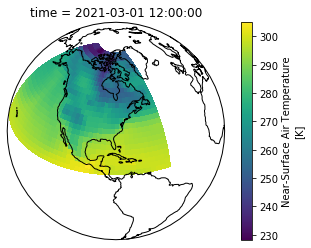

In [4]:
dataset = dataset.sel(lon=slice(190,310),lat=slice(10,80)).chunk(chunks={'time':100})
ax = plt.axes(projection=ccrs.Orthographic(-80, 35))
p = dataset.tas.sel(time='2021-03-01').plot(ax=ax,transform=ccrs.PlateCarree())
p.axes.set_global()
p.axes.coastlines()
plt.savefig('canesm2_temp_slice.png',format='png',bbox_inches='tight',dpi=400)

We can also flatten the map and zoom in:

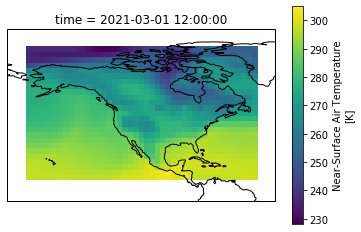

In [5]:
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=250))
p = dataset.tas.sel(time='2021-03-01',lon=slice(190,310),lat=slice(10,80)).plot(ax=ax,subplot_kws=dict(facecolor="gray"),transform=ccrs.PlateCarree())
p.axes.coastlines()
p.axes.set_xlim(-70,70)
p.axes.set_ylim(0,90)
plt.savefig('canesm2_temp.png',format='png',bbox_inches='tight',dpi=400)

The plots also demonstrate the slicing abilities of Xarray on the time and lat-lon coordinates. Slicing can be done over the coordinates to prepare a subset of the data for analysis (making the total computation less intensive). Geopotential height is a fourth variable that we are interested in including in our dataset, but it is an output of the CanESM2 model on a monthly scale. We can load it in and interpolate it down to daily timesteps:

In [6]:
zg = xr.open_dataset('zg_Amon_CanESM2_historical_rcp85_r1i1p1_195001-210012.nc')
zg = zg.sel(plev=50000.,lon=slice(200,300),lat=slice(20,70)).drop(['lat_bnds','lon_bnds','time_bnds','plev','plev_bnds'])
zg = zg['zg'].interp_like(dataset['pr']).ffill(dim='time').bfill(dim='time').compute()

Then, we can interpolate the monthly variable into the daily timestep, and store in the dataset with the other variables:

After matching the chunking and subselecting done before the interpolation, we can plot all four variables together:

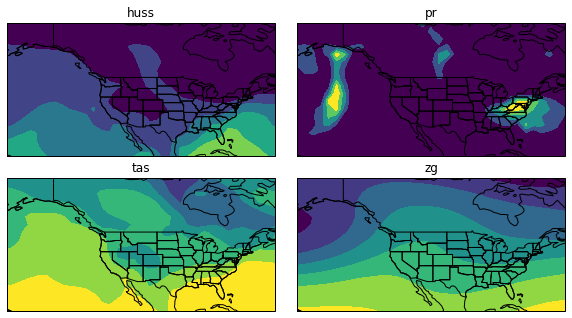

In [7]:
dataset = dataset.sel(lon=slice(200,300),lat=slice(20,70))
dataset['zg'] = zg.chunk(chunks={'time':100})
plot_data = dataset.sel(time='2021-03-01').squeeze().load()

from mpl_toolkits.axes_grid1 import AxesGrid,ImageGrid
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

axes_class = (GeoAxes,dict(map_projection=ccrs.PlateCarree(central_longitude=250)))
fig = plt.figure(figsize=(10,10))
axgr = ImageGrid(fig, 111, axes_class=axes_class,nrows_ncols=(2, 2),axes_pad=0.3,cbar_mode='None',label_mode='',)
for j, (ax, var) in enumerate(zip(axgr,plot_data.data_vars)):
    ax.add_feature(cfeature.STATES)
    ax.coastlines()
    im = plot_data[var].plot.contourf(ax=ax,transform=ccrs.PlateCarree(),add_colorbar=False)
    ax.set_title(var)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig('canesm2_fields.png',format='png',bbox_inches='tight',dpi=400)


And now we can do some real computation:

In [8]:
dataset = dataset.chunk(chunks={'time':500}) # to parallelize operation
symmetry = dataset + dataset.transpose() - dataset*dataset.transpose()
symmetry.compute()

<xarray.Dataset>
Dimensions:  (lat: 18, lon: 35, time: 55115)
Coordinates:
  * lat      (lat) float64 20.93 23.72 26.51 29.3 ... 60.0 62.79 65.58 68.37
  * lon      (lon) float64 202.5 205.3 208.1 210.9 ... 289.7 292.5 295.3 298.1
  * time     (time) object 1950-01-01 12:00:00 ... 2100-12-31 12:00:00
Data variables:
    huss     (time, lat, lon) float32 0.03175981 0.03051545 ... 0.0052929535
    pr       (time, lat, lon) float32 4.095729e-05 ... 3.9293307e-05
    tas      (time, lat, lon) float32 -87697.52 -87489.75 ... -72428.43
    zg       (time, lat, lon) float64 -3.375e+07 -3.376e+07 ... -2.69e+07

Or do some statistics:

In [9]:
import pandas as pd
for var in dataset.data_vars:
    stats = pd.DataFrame(group[var].to_dataframe().describe().rename(columns={'score':name}).squeeze() for name,group in dataset.groupby('time.month'))
#     stats = pd.DataFrame(group[var].to_dataframe().describe().rename(columns={'score':name}).squeeze() for name,group in dataset.groupby('time.dayofyear')) # for higher time res
    stats.to_csv('canesm2_stats_monthly_{}.csv'.format(var)) # takes about 1 min per variable for monthly stats

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/gdst/Box Sync/meetings/dask_numba_xarray/tas_day_CanESM2_historical_rcp85_r1i1p1_19500101-21001231.nc'

And make some plots:

In [ ]:
import seaborn as sns
clrs = sns.color_palette("husl", 2)
fig, axes = plt.subplots(2,2,figsize=(8,6))
for i,(var,ax) in enumerate(zip(dataset.data_vars,axes.flatten())):
    df = pd.read_csv('canesm2_stats_monthly_{}.csv'.format(var),header=0,index_col=0)
    df.index = [d.strftime('%m') for d in pd.date_range('20130101','20131231', freq='M')]
#     df.index = [d.strftime('%m%d') for d in pd.date_range('20130101','20131231')] # for dayofyear version
    df['mean'].plot(ax=ax,c=clrs[0])
    ax.fill_between(df.index.values,df['mean']-df['std'],df['mean']+df['std'],alpha=0.3,facecolor=clrs[1],label='stdv')
    ax.legend(frameon=False)
    ax.set_title(var)
    ax.set_ylabel(dataset[var].attrs["units"])
    ax.set_xlabel('Month of Year')
    if var == 'pr':
        ax.set_ylim(bottom=0)#,top=12.5)
    ax.autoscale(enable=True, axis='x', tight=True)
fig.tight_layout(pad=1.0)
plt.savefig('canesm2_monthly_stats.png',format='png',bbox_inches='tight',dpi=400)
    

Here you have some basic applications of Xarray's broad functionality, but many are working to extend Xarray for different applications, such as [regridding](https://xesmf.readthedocs.io/en/latest/), [climate indices and bias correction algorithms](https://xclim.readthedocs.io/en/stable/index.html), and [machine learning](https://ml.dask.org/), to name a few. Additionally, as part of a larger project to move data access and analysis to the cloud, Xarray and other libraries such as Dask are being bundled together to make big data geoscience possible at [Pangeo](https://pangeo.io/).